In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# 模型内部机制：训练一个数字分类器

在第二章中，我们已经了解了实际训练各种模型的过程，现在让我们深入探索其内部机制，看看具体发生了什么。我们将从计算机视觉入手，介绍深度学习的基本工具和概念。

具体来说，我们将讨论数组和张量的作用，以及广播——一种利用它们进行高效表达的有力技术。我们将解释随机梯度下降（SGD），这是一种通过自动更新权重来实现学习的机制。我们还将探讨为我们的基本分类任务选择损失函数的方法，以及小批量（mini-batches）的作用。此外，我们还会描述一个基本神经网络实际执行的计算过程。最后，我们将把这些部分整合在一起。

在后续章节中，我们将深入探讨其他应用，并了解这些概念和工具如何推广。但本章的重点是奠定基础。坦率地说，这也使得本章成为最难的一章，因为这些概念相互依赖。就像拱门一样，所有的石块都需要到位，结构才能稳固。一旦完成，它就是一个强大的结构，可以支撑其他事物。但组装它需要一些耐心。

让我们开始吧。第一步是考虑计算机中图像是如何表示的。 

## 像素：计算机视觉的基础

要理解计算机视觉模型的工作机制，我们首先必须了解计算机是如何处理图像的。我们将使用计算机视觉领域最著名的数据集之一——[MNIST](https://en.wikipedia.org/wiki/MNIST_database)来进行实验。MNIST包含手写数字图像，这些图像由美国国家标准与技术研究院收集，后经扬·勒丘恩（Yann Lecun）及其同事整理成机器学习数据集。1998年，勒丘恩在[LeNet-5](http://yann.lecun.com/exdb/lenet/)中使用了MNIST，而LeNet-5是首个展现出具有实际应用价值的手写数字序列识别能力的计算机系统，这也是人工智能史上最重要的突破之一。

## 边栏：坚持与深度学习

深度学习的发展史，是少数执着的研究者凭借坚韧与毅力所书写的篇章。在早期的希望（以及炒作）之后，神经网络在20世纪90年代至21世纪初逐渐失宠，仅有少数研究者仍在坚持探索如何让其高效运转。其中，扬·勒丘恩（Yann Lecun）、约书亚·本吉奥（Yoshua Bengio）和杰弗里·辛顿（Geoffrey Hinton）三人，尽管长期面临主流机器学习与统计学界的深度质疑和漠视，却最终取得了突破，并于2018年荣获计算机科学领域的最高荣誉——图灵奖（通常被视为“计算机界的诺贝尔奖”）。

杰弗里·辛顿曾提到，即便有些学术论文所呈现的结果远优于以往发表的任何成果，仅因使用了神经网络，就会被顶级期刊和会议拒之门外。扬·勒丘恩在卷积神经网络方面的研究（我们将在下一节展开学习），证实了这类模型能够识别手写文本——这是此前从未实现过的突破。然而，即便这项技术已投入商业应用，承担了美国10%的支票识别工作，他的这一成果仍被多数研究者忽视！

除了这三位图灵奖得主，还有许多研究者为推动深度学习发展到如今的境地而不懈奋斗。例如，于尔根·施密德胡贝尔（Jurgen Schmidhuber，许多人认为他本应共享图灵奖）开创了诸多重要理念，包括与学生塞普·霍克里特（Sepp Hochreiter）共同提出的长短期记忆（LSTM）架构——该架构广泛应用于语音识别和其他文本建模任务，在《第一章》的IMDb示例中也有使用。或许最为重要的是，保罗·沃博斯（Paul Werbos）在1974年发明了神经网络的反向传播算法——本章将介绍这一技术，如今它已成为训练神经网络的通用方法（[Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)）。他的这一成果在数十年间几乎完全被忽视，但如今已被视作现代人工智能最重要的基石。

这对我们所有人都有所启示！在你的深度学习探索之路上，会遇到诸多阻碍，既有技术层面的，也有（更棘手的）来自周遭不相信你能成功的人的质疑。有一种失败是注定的，那就是停止尝试。我们发现，每一位从fast.ai走出、成长为世界级实践者的学生，身上都有一个共同特质——他们都极具韧性。

## 边栏结束

在这个入门教程中，我们仅尝试创建一个模型，使其能够将任何图像分类为数字3或7。因此，让我们下载MNIST数据集中仅包含这两个数字图像的样本：

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

我们可以使用`ls`方法查看该目录下的内容，这是fastai新增的一个方法。该方法会返回一个fastai特殊类`L`的对象，这个类不仅具备Python内置`list`的所有功能，还额外增加了许多特性。其中一个便捷之处是，打印该对象时，会先显示项目的数量，然后再列出项目本身（如果项目数量超过10个，则只显示前几个）：

In [ ]:
path.ls()

(#9) [Path('cleaned.csv'),Path('item_list.txt'),Path('trained_model.pkl'),Path('models'),Path('valid'),Path('labels.csv'),Path('export.pkl'),Path('history.csv'),Path('train')]

MNIST数据集采用了机器学习数据集的一种常见布局：训练集和验证集（以及/或者测试集）分别存放在不同的文件夹中。我们来看看训练集里面有什么：

In [ ]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

这里有一个存放数字3图像的文件夹，还有一个存放数字7图像的文件夹。在机器学习术语中，我们将“3”和“7”称为该数据集中的**标签**（或目标）。我们来查看其中一个文件夹（使用`sorted`函数以确保大家看到的文件顺序一致）：

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

正如我们所料，这里面全是图像文件。现在我们来看其中一张。这是一张手写数字3的图像，来自著名的MNIST手写数字数据集：

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

这里我们使用的是来自“Python图像处理库”（PIL）的`Image`类，这是Python中用于打开、处理和查看图像最广泛的工具包。Jupyter能够识别PIL图像，因此会自动为我们显示图像。

在计算机中，所有事物都以数字形式表示。要查看构成这张图像的数字，我们需要将其转换为**NumPy数组**或**PyTorch张量**。例如，下面是图像的一部分转换为NumPy数组后的样子：

In [ ]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

`4:10`表示我们选取了索引从4（包含）到10（不包含）的行，列的选取方式相同。NumPy的索引顺序是从上到下、从左到右，因此这段数据对应的是图像左上角的区域。下面是转换为PyTorch张量后的相同内容：

In [ ]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

我们可以对数组进行切片，只选取包含数字顶部的部分，然后使用Pandas的DataFrame通过渐变色对这些值进行编码。这样就能清晰地展示图像是如何由像素值构成的：

In [ ]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<img width="453" id="output_pd_pixels" src="images/att_00058.png">

可以看到，背景的白色像素存储为数字0，黑色像素存储为数字255，而灰色像素的值则介于两者之间。整幅图像的横向和纵向各有28个像素，总共有784个像素。（这比手机相机拍摄的图像小得多，手机图像通常包含数百万个像素，但对于我们初步的学习和实验来说，这个尺寸很合适。我们很快就会学习更大的全彩色图像相关内容。）

既然你已经了解了图像在计算机中的呈现方式，我们来回顾一下目标：创建一个能够识别3和7的模型。你会如何让计算机实现这一功能呢？

> 提示：停下来思考一下！在继续阅读之前，花点时间想一想计算机如何才能识别这两个不同的数字。它可能会关注哪些特征？它如何识别这些特征？又如何将这些特征组合起来？主动尝试解决问题比仅仅阅读别人的答案更有利于学习，所以请暂时放下这本书，拿一张纸和一支笔，记下一些想法……

## 首次尝试：像素相似度

那么，第一个思路是这样的：我们可以计算所有3的图像中每个像素的平均值，然后对7的图像也做同样的计算。这样我们就能得到两个群体平均值，它们可以定义我们所说的“理想”3和“理想”7。之后，要将一幅图像分类为其中一个数字时，我们只需看这幅图像与这两个理想数字中的哪一个更相似即可。这显然应该比毫无依据的判断要好，因此可以作为一个不错的基准。

> 术语：基准（Baseline）：一个你有信心能表现得还不错的简单模型。它应该易于实现且便于测试，这样你就能测试每一个改进的想法，并确保它们始终优于基准。如果不从一个合理的基准开始，就很难判断你那些超级复杂的模型是否真的有效。创建基准的一个好方法是我们这里所做的：设计一个简单、易于实现的模型。另一个好方法是寻找那些解决过与你类似问题的人，下载他们的代码并在你的数据集上运行。理想情况下，两种方法都可以尝试！

我们这个简单模型的第一步，是计算两个数字组中每个像素值的平均值。在这个过程中，我们会学到很多实用的Python数值编程技巧！

我们来创建一个张量，将所有的3的图像堆叠在一起。我们已经知道如何创建包含单张图像的张量。要创建包含一个目录中所有图像的张量，我们首先会使用Python列表推导式来创建一个由单张图像张量组成的普通列表。

我们会用Jupyter随时对操作进行一些小检查——这里要确保返回的项目数量看起来是合理的：

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

> 注：列表推导式：列表推导式和字典推导式是Python的一大特色。许多Python程序员（包括本书作者）每天都会用到它们——它们是“地道Python风格”的一部分。但从其他编程语言转过来的程序员可能从未见过。网上有很多很棒的教程，只需搜索一下就能找到，所以我们现在就不花太多时间讨论了。这里给出一个快速解释和示例帮你入门。列表推导式的形式如下：`new_list = [f(o) for o in a_list if o>0]`。它会先筛选出`a_list`中所有大于0的元素，再将这些元素传入函数`f`，最后返回处理后的结果组成的列表。这里包含三个部分：要迭代的集合（`a_list`）、可选的筛选条件（`if o>0`），以及对每个元素执行的操作（`f(o)`）。它不仅写起来更简洁，而且比用循环创建相同列表的其他方式快得多。

我们还要检查其中一张图像是否正常。由于我们现在处理的是张量（Jupyter默认会将其打印为数值），而非PIL图像（Jupyter默认会将其显示为图像），因此需要使用fastai的`show_image`函数来显示图像：

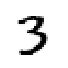

In [ ]:
show_image(three_tensors[1]);

对于每个像素位置，我们需要计算所有图像中该像素亮度的平均值。要做到这一点，首先要将列表中的所有图像合并成一个三维张量。这种张量最常见的描述方式是称之为**三阶张量**。我们经常需要将一个集合中的各个张量堆叠成一个单一的张量。不出所料，PyTorch提供了一个名为`stack`的函数，可用于此目的。

PyTorch中的一些操作（例如求均值）要求我们将整数类型**转换**为浮点类型。由于之后会用到这一点，我们现在就将堆叠后的张量转换为`float`类型。在PyTorch中进行类型转换非常简单，只需输入想要转换到的类型名称，并将其当作一个方法来使用即可。

通常，当图像以浮点类型表示时，像素值应在0到1之间，因此我们在这里还要除以255：

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

张量最重要的属性或许是它的**形状（shape）**。形状会告诉你每个轴的长度。在这个例子中，我们可以看到有6131张图像，每张图像的尺寸为28×28像素。这个张量本身并没有明确表明第一个轴代表图像数量、第二个轴代表高度、第三个轴代表宽度——张量的语义完全取决于我们以及我们构建它的方式。在PyTorch看来，它仅仅是内存中的一堆数字而已。

张量形状的**长度**就是它的阶（rank）：

In [ ]:
len(stacked_threes.shape)

3

你一定要记住并练习这些张量术语：**阶（rank）** 指的是张量中轴（axis）或维度的数量；**形状（shape）** 指的是张量每个轴的大小。

> 补充说明：要注意“维度（dimension）”一词有时有两种用法。比如，我们生活在“三维空间”中，一个物理位置可以用一个三维向量`v`来描述。但在PyTorch中，`v.ndim`这个属性（看起来像是`v`的“维度数量”）却等于1，而不是3！这是为什么呢？因为`v`是一个向量，属于一阶张量，意味着它只有一个**轴**（即便这个轴的长度是3）。换句话说，“维度”有时指的是轴的大小（“空间是三维的”）；有时又指阶，即轴的数量（“矩阵有两个维度”）。当感到困惑时，我发现把所有表述都转换成阶、轴和长度这些含义明确的术语会很有帮助。

We can also get a tensor's rank directly with `ndim`:

In [ ]:
stacked_threes.ndim

3

最后，我们可以计算出“理想的3”是什么样子。我们通过对堆叠后的三阶张量沿0维求均值，来计算所有图像张量的平均值。0维正是遍历所有图像的维度。

换句话说，对于每个像素位置，这一步会计算该像素在所有图像中的平均值。结果将是每个像素位置对应一个值，也就是形成单张图像。如下所示：

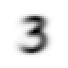

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

根据这个数据集，这就是理想中的数字3！（你可能不喜欢它，但这就是巅峰状态的3该有的样子。）可以看到，在所有图像都认为应该是深色的地方，它的颜色很深；而在图像存在分歧的地方，它就显得模糊不清。

我们用同样的方法处理数字7，不过为了节省时间，我们把所有步骤合并在一起进行：

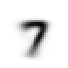

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

现在我们任选一个3，来测量它与我们的“理想数字”之间的**距离**。

> 暂停：停下来思考一下！你会如何计算某张图像与我们的每个理想数字的相似度呢？记得先放下这本书，记下一些想法再继续往下读！研究表明，当你通过自己解决问题、进行实验和尝试新想法来参与学习过程时，记忆和理解会显著提升。

这是一个3的样本：

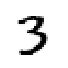

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

我们如何确定它与理想的3之间的距离呢？我们不能简单地把这张图像的像素与理想数字的像素之间的差值相加。因为有些差值是正的，有些是负的，这些差值会相互抵消，导致一种误导性的结果：比如一张在某些地方过暗、在另一些地方过亮的图像，可能会被显示为与理想数字的总差值为零。

为了避免这种情况，数据科学家在这种场景下主要采用两种方法来测量距离：

- 计算差值的**绝对值**的平均值（绝对值函数会将负值转换为正值）。这被称为**平均绝对差**（mean absolute difference）或**L1范数**（L1 norm）。
- 计算差值的**平方**的平均值（这样能让所有值都变为正数），然后取**平方根**（以抵消平方操作）。这被称为**均方根误差**（root mean squared error，RMSE）或**L2范数**（L2 norm）。

> 重要提示：忘记数学知识也没关系：在本书中，我们通常假设你已经学完了高中数学，并且至少记得其中的一部分……但每个人都会忘记一些东西！这完全取决于你在此期间有机会练习哪些内容。或许你已经忘记了什么是**平方根**，或者它的具体运算方式。没关系！每当你遇到本书中没有详细解释的数学概念时，不要继续往下读，而是停下来去查阅相关资料。确保你理解其基本概念、运算方式以及我们使用它的原因。可汗学院（Khan Academy）是巩固知识的绝佳平台之一。例如，可汗学院有一个很棒的[平方根入门教程](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots)。

现在我们来尝试这两种方法：

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

在这两种情况下，我们所选的3与“理想的3”之间的距离都小于它与理想的7之间的距离。因此，我们的简单模型在这种情况下会给出正确的预测。

PyTorch已经将这两种方法作为**损失函数**提供。你可以在`torch.nn.functional`中找到它们，PyTorch团队建议将其导入为`F`（在fastai中，该名称默认可用）：

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

这里的`mse`代表**均方误差**（mean squared error），`l1`则是**平均绝对值**的标准数学术语（在数学中称为**L1范数**）。

> 西尔万：补充说明：直观来说，L1范数和均方误差（MSE）的区别在于，后者对较大的误差的惩罚会比前者更严厉（而对小误差则更为宽容）。

> 杰里米：我第一次遇到这个“L1”玩意儿的时候，特意查了查它到底是什么意思。我在谷歌上查到，它是一种使用**绝对值**的**向量范数**，于是又去查“向量范数”，然后开始读：“设V是实数域或复数域F上的向量空间，V上的范数是一个非负值函数p: V → [0,+∞)，满足以下性质：对任意a ∈ F和任意u, v ∈ V，有p(u + v) ≤ p(u) + p(v)……” 然后我就停下来了。“唉，我永远也搞不懂数学！”我又一次这么想，这已经是第无数次了。从那以后我才明白，每当在实际应用中遇到这些复杂的数学术语时，其实我都能用一小段代码来替代它们！比如，**L1损失**其实就是`(a-b).abs().mean()`，其中`a`和`b`是张量。我猜搞数学的人思考方式和我不一样吧……在这本书里，我保证每当出现一些数学术语时，都会给你对应的一小段代码，并用通俗易懂的语言解释其中的原理。

我们刚刚在PyTorch张量上完成了各种数学运算。如果你之前用PyTorch做过数值编程，可能会发现它们和NumPy数组很相似。我们来看看这两种非常重要的数据结构。

### NumPy数组与PyTorch张量

[NumPy](https://numpy.org/)是Python中用于科学计算和数值编程的最广泛使用的库。它提供的功能和API与PyTorch非常相似；然而，它不支持使用GPU或计算梯度，而这两者对于深度学习来说都至关重要。因此，在本书中，只要有可能，我们通常会使用PyTorch张量而非NumPy数组。

（注意：fastai为NumPy和PyTorch添加了一些功能，使它们彼此更相似一些。如果本书中的任何代码在你的电脑上无法运行，有可能是你忘记在笔记本的开头加入这样一行代码：`from fastai.vision.all import *`。）

但数组和张量究竟是什么，你又为什么要关注它们呢？

与许多语言相比，Python的速度较慢。在Python、NumPy或PyTorch中，任何快速的操作都很可能是对用其他语言（特别是C语言）编写（并优化）的编译对象的封装。事实上，**NumPy数组和PyTorch张量的计算速度可能比纯Python快数千倍**。

NumPy数组是一个多维的数据表，其中所有元素的类型相同。由于元素可以是任何类型，它们甚至可以是数组的数组，且最内层的数组可能具有不同的大小——这被称为“不规则数组（jagged array）”。所谓“多维数据表”，例如，一维的列表、二维的表格或矩阵、三维的“表中表”或“立方体”等等。如果元素都是整数或浮点数等简单类型，那么NumPy会将它们在内存中存储为紧凑的C语言数据结构。这正是NumPy的优势所在。NumPy拥有各种各样的运算符和方法，能够以与优化后的C语言相同的速度对这些紧凑结构进行计算，因为这些运算符和方法本身就是用优化后的C语言编写的。

PyTorch张量几乎与NumPy数组相同，但它有一个额外的限制，而这个限制也解锁了一些额外的功能。两者的相同点在于，它们都是多维数据表，且所有元素类型相同。但区别在于，张量不能使用任意类型——它所有的组成部分必须使用单一的基本数值类型。例如，PyTorch张量不能是不规则的，它始终是形状规则的多维矩形结构。

NumPy在这些结构上支持的绝大多数方法和运算符，PyTorch也支持，但PyTorch张量还有额外的功能。一个主要功能是，这些结构可以存在于GPU上，此时它们的计算会针对GPU进行优化，并且在处理大量数据时能运行得更快。此外，PyTorch可以自动计算这些操作（包括操作组合）的导数。你将会发现，没有这种能力，实际上就无法进行深度学习。

> 补充说明：如果你不知道C语言是什么，也不用担心，因为你完全用不到它。简而言之，它是一种低级语言（低级意味着更接近计算机内部使用的语言），与Python相比速度非常快。为了在Python编程时利用其速度优势，应尽可能避免编写循环，而是用直接对数组或张量进行操作的命令来替代。

对于Python程序员来说，需要学习的最重要的新编程技能可能是如何有效地使用数组/张量API。本书后面会展示更多技巧，但这里先总结一下你目前需要了解的关键内容。

要创建数组或张量，可将一个列表（或列表的列表、列表的列表的列表等）传递给`array()`或`tensor()`：

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

接下来所有操作都以张量为例进行展示，但对于NumPy数组，其语法和结果是完全相同的。

你可以选取一行（注意，和Python中的列表一样，张量也是从0开始索引的，所以1指的是第二行/列）：

In [ ]:
tns[1]

tensor([4, 5, 6])

或者选取一列，方法是使用`:`表示“第一轴的所有元素”（我们有时会将张量/数组的维度称为**轴**）：

In [ ]:
tns[:,1]

tensor([2, 5])

你可以将这些与Python的切片语法（`[start:end]`，其中`end`对应的元素不包含在内）结合使用，以选取行或列的一部分：

In [ ]:
tns[1,1:3]

tensor([5, 6])

你还可以使用标准运算符，如`+`、`-`、`*`、`/`：

In [ ]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [ ]:
tns.type()

'torch.LongTensor'

并且会根据需要自动更改类型，例如从`int`（整数）变为`float`（浮点数）：

In [ ]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

那么，我们的基准模型到底好不好呢？要对此进行量化，我们必须定义一个评估指标。

## 使用广播计算评估指标

回想一下，评估指标是根据模型的预测结果和数据集中的正确标签计算得出的一个数值，用于衡量模型的好坏。例如，我们可以使用上一节中见过的均方误差或平均绝对误差函数，然后计算整个数据集上的平均值。不过，这两个指标对大多数人来说都不太容易理解；在实际应用中，我们通常使用**准确率**作为分类模型的评估指标。

正如我们所讨论的，我们要在**验证集**上计算评估指标。这样做是为了避免无意中出现过拟合现象——即训练出一个只在训练数据上表现良好的模型。对于我们这里作为初次尝试的像素相似度模型来说，其实并不存在这种风险，因为它没有需要训练的组件，但为了遵循常规做法，也为了给后面的第二次尝试做好准备，我们还是会使用验证集。

要得到验证集，我们需要从训练数据中完全剔除一部分数据，让模型根本看不到这部分数据。事实上，MNIST数据集的创建者已经为我们做好了这件事。你还记得有一个单独的目录叫“valid”吗？这个目录就是用来存放验证集的！

那么，首先我们从这个目录中为数字3和7创建张量。我们将使用这些张量来计算评估指标，以此衡量我们初次尝试的模型（通过与理想图像的距离来进行判断的模型）的性能：

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

养成随时检查形状的习惯是个好主意。在这里，我们看到两个张量，一个代表验证集中的3，包含1010张尺寸为28×28的图像；另一个代表验证集中的7，包含1028张尺寸为28×28的图像。

我们最终想要编写一个名为`is_3`的函数，用来判断任意一张图像是3还是7。它的判断依据是：这张任意图像与我们的两个“理想数字”中的哪一个更接近。为此，我们需要定义一种距离概念——也就是一个计算两张图像之间距离的函数。

我们可以编写一个简单的函数来计算平均绝对误差，其表达式与我们上一节中写的非常相似：

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

这与我们之前计算两张图像（即理想的3的张量`mean_3`和任意一个3的样本张量`a_3`，两者都是形状为`[28,28]`的单图像张量）之间距离得到的值是一样的。

但为了计算整体准确率这一评估指标，我们需要计算验证集中**每一张**图像与理想的3之间的距离。该如何进行这项计算呢？我们可以遍历验证集张量`valid_3_tens`中堆叠的所有单图像张量（`valid_3_tens`的形状为`[1010,28,28]`，代表1010张图像）。不过，还有一种更好的方法。

如果我们用这个原本用于比较两张单图像的距离函数，传入代表3的验证集的张量`valid_3_tens`作为参数，会发生一件很有意思的事：

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1050, 0.1526, 0.1186,  ..., 0.1122, 0.1170, 0.1086]),
 torch.Size([1010]))

它并没有因为形状不匹配而报错，而是返回了一个长度为1010（即我们验证集中3的数量）的向量（也就是一个1阶张量），其中每个元素对应一张图像的距离。这是怎么做到的呢？

再看看我们的`mnist_distance`函数，你会发现其中有减法运算`(a-b)`。这里的神奇之处在于，当PyTorch尝试对两个不同阶数的张量执行简单的减法运算时，会使用**广播（broadcasting）** 机制。也就是说，它会自动扩展阶数较小的张量，使其与阶数较大的张量具有相同的尺寸。广播是一项重要功能，能让张量代码的编写变得简单得多。

在通过广播使两个输入张量具有相同阶数后，PyTorch会对两个同阶张量应用其常规逻辑：对两个张量的每个对应元素执行运算，并返回运算结果张量。例如：

In [ ]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

因此，在这种情况下，PyTorch会将`mean3`（一个代表单张图像的2阶张量）视作1010个相同图像的副本，然后用验证集中的每一张3的图像分别减去这些副本。你认为得到的这个张量会是什么形状？先试着自己推导一下，再看下面的答案：

In [ ]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

我们正在计算“理想的3”与验证集中1010张3的图像中每张图像之间的差异，针对每张28×28的图像，最终得到的形状为`[1010,28,28]`。

关于广播的实现方式，有几个重要要点，这些要点使其不仅在表达性上有价值，在性能上也同样出色：
- PyTorch**实际上并不会**将`mean3`复制1010次。它只是“假装”这是一个具有该形状的张量，而不会实际分配额外的内存。
- 整个计算是在C语言中进行的（如果你使用GPU，就是在CUDA中进行，CUDA相当于GPU上的C语言），其速度比纯Python快数成千上万倍（在GPU上甚至能快数百万倍！）。

PyTorch中所有的广播以及逐元素操作和函数都是如此。**这是你编写高效PyTorch代码需要掌握的最重要技巧**。

在`mnist_distance`函数接下来的部分，我们看到了`abs`。现在你或许能猜到，当它应用于张量时会做什么。它会对张量中的每个元素应用该方法，并返回一个包含结果的张量（也就是说，它会“逐元素”应用该方法）。因此，在这种情况下，我们会得到1010个绝对值矩阵。

最后，我们的函数调用了`mean((-1,-2))`。元组`(-1,-2)`代表了一组轴的范围。在Python中，`-1`指最后一个元素，`-2`指倒数第二个元素。所以在这种情况下，这告诉PyTorch我们想要对张量最后两个轴所索引的值求平均值。最后两个轴是图像的水平和垂直维度。在对最后两个轴求平均值后，我们只剩下第一个张量轴，该轴用于索引我们的图像，这就是为什么最终的大小是`(1010)`。换句话说，对于每张图像，我们对该图像中所有像素的强度取了平均值。

在本书中，我们会学习更多关于广播的知识，尤其是在《第十七章》中，并且也会定期练习。

我们可以使用`mnist_distance`函数来判断一张图像是不是3，其逻辑如下：如果所讨论的数字与理想的3之间的距离小于它与理想的7之间的距离，那么它就是3。这个函数会自动进行广播并逐元素应用，就像所有的PyTorch函数和运算符一样：

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

让我们在示例情况上测试一下：

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

注意，当我们将布尔值结果转换为浮点数时，`True`会变为`1.0`，`False`会变为`0.0`。借助广播机制，我们还可以在整个3的验证集上进行测试：

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

现在，我们可以通过计算该函数在所有3的图像上的平均值，以及其相反情况在所有7的图像上的平均值，来分别得到3和7的准确率：

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

这看起来是个相当不错的开端！我们在3和7的分类上都达到了90%以上的准确率，而且我们已经了解了如何利用广播机制方便地定义评估指标。

但说实话：3和7是外观差异很大的数字。而且到目前为止，我们只对10个可能的数字中的2个进行了分类。所以我们还需要做得更好！

要做得更好，或许是时候尝试一种能进行真正学习的系统了——也就是说，这种系统能够自动调整自身以提升性能。换句话说，是时候讨论训练过程和随机梯度下降（SGD）了。

## 随机梯度下降 (SGD)

你还记得我们在《第一章》中引用的阿瑟·塞缪尔对机器学习的描述吗？

> 假设我们设置某种自动方法，根据实际表现来测试当前权重分配的有效性，并提供一种机制来调整权重分配以最大化性能。我们无需深入这种程序的细节就能明白，它可以完全自动化，而且经过这样编程的机器会从经验中“学习”。

正如我们所讨论的，这是让模型能够不断改进——能够学习的关键。但我们的像素相似度方法其实做不到这一点。我们没有任何形式的权重分配，也没有基于测试权重分配有效性来进行改进的方法。换句话说，我们无法通过修改一组参数来真正改进像素相似度方法。为了利用深度学习的力量，我们首先必须按照阿瑟·塞缪尔所描述的方式来呈现我们的任务。

我们不必尝试寻找图像与“理想图像”之间的相似度，而是可以观察每个单独的像素，并为每个像素设定一组权重，这样一来，权重最高的像素就与特定类别中最可能为黑色的像素相关联。例如，右下角的像素对于数字7来说不太可能被激活，因此它们在7的权重中应该较低，但对于数字8来说可能会被激活，因此在8的权重中应该较高。这可以用一个函数和每组可能类别的权重值来表示——例如，是数字8的概率：

```python
def pr_eight(x,w): return (x*w).sum()
```

这里我们假设`x`是图像，以向量形式表示——换句话说，就是将所有行首尾相连堆叠成一条长长的线。同时我们假设权重是一个向量`w`。如果有了这个函数，我们只需要某种方法来更新权重，让它们变得更好一点。通过这样的方法，我们可以多次重复这一步骤，让权重越来越优，直到达到我们能做到的最佳状态。

我们希望找到向量`w`的特定值，使得对于实际是8的图像，函数结果较高；而对于不是8的图像，函数结果较低。寻找最佳向量`w`的过程，就是寻找识别8的最佳函数的过程。（由于我们还没有使用深度神经网络，函数的能力受到限制——本章后面会解决这个约束问题。）

更具体地说，要将这个函数转变为机器学习分类器，我们需要执行以下步骤：

1. **初始化**权重。
1. 对于每张图像，使用这些权重来**预测**它看起来是3还是7。
1. 根据这些预测，计算模型的表现好坏（即其**损失**）。
1. 计算**梯度**，梯度用于衡量每个权重的变化会如何影响损失的变化。
1. 基于梯度的计算结果来**调整**所有权重。
1. 返回步骤2，**重复**整个过程。
1. 反复迭代，直到决定**停止**训练过程（例如，因为模型表现已经足够好，或者不想再继续等待）。

这七个步骤是所有深度学习模型训练的核心。深度学习竟然完全依赖于这些步骤，这极其令人惊讶且违背直觉。如此一个过程能够解决如此复杂的问题，实在令人惊叹。但正如你将看到的，它确实能做到！

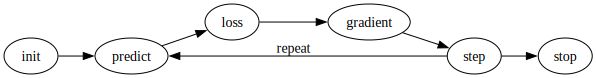

In [3]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

这七个步骤中的每一步都有许多不同的实现方式，我们将在本书的其余部分学习这些内容。对于深度学习从业者来说，这些细节会产生很大影响，但事实证明，每个步骤的通用方法通常遵循一些基本原理。以下是一些指导原则：

- 初始化（Initialize）：我们将参数初始化为随机值。这听起来可能有些令人惊讶。当然，我们也可以有其他选择，例如根据某一类别中像素被激活的百分比来初始化参数——但由于我们已经知道有一套程序可以改进这些权重，事实证明，仅仅从随机权重开始就完全可行。
- 损失（Loss）：这就是塞缪尔所说的“根据实际表现来测试当前权重分配的有效性”。我们需要某种函数，当模型表现良好时，该函数返回一个较小的数值（标准做法是将较小的损失视为良好，较大的损失视为糟糕，尽管这只是一种约定）。
- 调整（Step）：要弄清楚一个权重应该稍微增加还是减少，一个简单的方法是直接尝试：将权重增加一小部分，看看损失是上升还是下降。一旦找到正确的方向，你就可以再多调整一点，或者少调整一点，直到找到一个合适的调整量。然而，这种方法很慢！正如我们将看到的，微积分的神奇之处在于，它能让我们直接确定每个权重应该朝哪个方向调整以及大致调整多少，而不必尝试所有这些微小的变化。实现这一点的方法是计算**梯度**。这只是一种性能优化，使用较慢的手动过程也能得到完全相同的结果。
- 停止（Stop）：一旦我们决定了模型的训练轮数（前面的列表中给出了一些建议），就可以按照这个决定执行。这正是该决定的应用之处。对于我们的数字分类器，我们会持续训练，直到模型的准确率开始下降，或者我们的时间耗尽。

在将这些步骤应用到我们的图像分类问题之前，让我们先在一个更简单的案例中说明它们的具体过程。首先，我们来定义一个非常简单的函数——二次函数，假设它就是我们的损失函数，而`x`是该函数的一个权重参数：

In [ ]:
def f(x): return x**2

下面是该函数的图像：

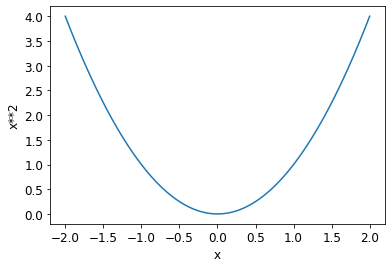

In [ ]:
plot_function(f, 'x', 'x**2')

我们前面描述的步骤序列首先要为参数选取某个随机值，然后计算损失值：

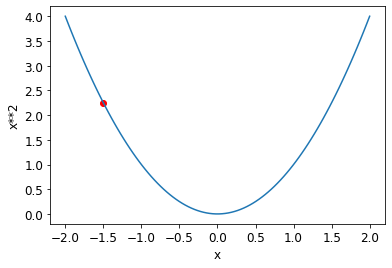

In [ ]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

现在我们来看看，如果将参数稍微增大或减小一点（即进行**调整**），会发生什么情况。这其实就是特定点处的斜率：

<img alt="A graph showing the squared function with the slope at one point" width="400" src="images/grad_illustration.svg"/>

我们可以沿着斜率的方向稍微调整权重，重新计算损失和调整量，然后重复这个过程几次。最终，我们会到达曲线上的最低点：

<img alt="An illustration of gradient descent" width="400" src="images/chapter2_perfect.svg"/>

这一基本思想可以一直追溯到艾萨克·牛顿，他指出我们可以用这种方式优化任意函数。无论函数变得多么复杂，梯度下降这一基本方法都不会有显著变化。在本书后面的内容中，我们只会看到一些细微的调整，比如通过找到更优的步长来加快优化速度的实用方法。

### 计算梯度

其中最关键的一步是计算梯度。正如我们所提到的，我们借助微积分来优化性能，它能让我们更快速地判断当调整参数（增大或减小）时，损失会随之上升还是下降。换句话说，梯度会告诉我们，为了让模型性能更好，每个权重需要调整多少。

你可能还记得高中微积分课上的内容：函数的**导数**能告诉你参数的变化会如何影响函数结果的变化。如果不记得也没关系，很多人高中毕业后就把微积分知识忘了！但在继续学习之前，你需要对导数有一些直观的理解，所以如果这部分内容在你脑海中已经很模糊了，建议去可汗学院（Khan Academy）学习一下[基本导数的课程](https://www.khanacademy.org/math/differential-calculus/dc-diff-intro)。你不需要自己动手计算导数，只需要知道导数是什么就行。

关于导数，核心要点是：对于任何函数（比如我们上一节中看到的二次函数），我们都可以计算它的导数。导数本身也是一个函数，它计算的是变化量，而非函数值。例如，二次函数在值为3处的导数，告诉我们该函数在值为3处的变化率。更具体地说，你可能记得梯度的定义是“上升量除以运行量”（rise/run），即函数值的变化量除以参数值的变化量。当我们知道函数会如何变化时，就知道需要做些什么来让它变小。这正是机器学习的关键：找到一种方法来调整函数的参数，使函数值（损失）减小。微积分为我们提供了一个计算捷径——导数，让我们能够直接计算函数的梯度。

需要注意的一点是，我们的函数有很多需要调整的权重，因此在计算导数时，我们不会只得到一个数值，而是会得到很多个——每个权重都对应一个梯度。但这在数学上并没有什么复杂之处：你可以针对一个权重计算导数，同时将所有其他权重视为常数，然后对每个其他权重重复此操作。所有权重的梯度都是通过这种方式计算出来的。

我们刚才提到，你不必自己计算任何梯度。这是如何实现的呢？令人惊奇的是，PyTorch能够自动计算几乎所有函数的导数！而且，它的计算速度非常快。大多数情况下，其速度至少与你手动创建的任何导数函数相当。让我们来看一个例子。

首先，我们选取一个需要计算梯度的张量值：

In [ ]:
xt = tensor(3.).requires_grad_()

注意到那个特殊的方法`requires_grad_`了吗？这是我们用来告诉PyTorch，我们想要计算该变量在当前值处的梯度的“魔法咒语”。它本质上是给这个变量打上标记，这样PyTorch就会记住跟踪相关的计算过程，以便在需要时计算该变量的梯度——包括你后续对它进行的各种直接计算。

> 补充说明：如果你有数学或物理背景，这个API可能会让你感到困惑。在这些领域中，函数的“梯度”本身就是另一个函数（即其导数），所以你可能会期望与梯度相关的API会返回一个新的函数。但在深度学习中，“梯度”通常指的是函数的导数在某个特定参数值处的**数值**。PyTorch的API也将重点放在了参数上，而不是你实际要计算梯度的函数上。一开始可能会觉得这种方式有些颠倒，但这只是视角不同而已。

现在我们用这个值来计算函数。注意，PyTorch不仅会打印计算出的结果，还会附带说明它有一个梯度函数，以便在需要时用来计算我们的梯度：

In [ ]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

最后，我们让PyTorch为我们计算梯度：

In [ ]:
yt.backward()

这里的“backward”指的是**反向传播**（backpropagation），这是计算每一层导数的过程的名称。在《第十七章》中，当我们从头开始计算深度神经网络的梯度时，会详细了解其具体实现方式。这一过程被称为网络的“反向传播步骤”（backward pass），与之相对的是“前向传播步骤”（forward pass），即计算激活值的过程。如果`backward`直接被命名为`calculate_grad`，可能会更通俗易懂，但深度学习领域的研究者们确实很喜欢在各处加入专业术语！

现在，我们可以通过查看张量的`grad`属性来获取梯度：

In [ ]:
xt.grad

tensor(6.)

如果你还记得高中的微积分法则，`x**2`的导数是`2*x`，而我们这里的`x`值为3，所以梯度应该是`2*3=6`，这与PyTorch计算出的结果一致！

现在我们重复前面的步骤，但这次函数的输入是一个向量：

In [ ]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

我们会在函数中加入`sum`操作，这样它就可以接收一个向量（即1阶张量）并返回一个标量（即0阶张量）：

In [ ]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

我们得到的梯度是`2*xt`，这与我们预期的一致！

In [ ]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

梯度只告诉我们函数的斜率，并没有确切告诉我们参数应该调整多少。但它能给我们一些关于调整幅度的提示：如果斜率很大，可能意味着我们还需要进行较大幅度的调整；而如果斜率很小，则可能表明我们已经接近最优值了。

### 使用学习率进行调整

基于梯度值来决定如何调整参数，是深度学习过程中的一个重要环节。几乎所有方法都始于一个基本思路：将梯度乘以某个较小的数，这个数被称为**学习率**（LR）。学习率通常是一个介于0.0001到0.1之间的数，但也可以是其他值。人们往往通过尝试几个不同的学习率，然后选择能让模型在训练后表现最佳的那个（本书后面会介绍一种更好的方法，叫做**学习率查找器**）。一旦选定了学习率，就可以用下面这个简单的函数来调整参数：

```python
w -= gradient(w) * lr
```

这被称为对参数进行**调整**（stepping），也叫**优化器步骤**（optimizer step）。

如果选择的学习率过低，可能意味着需要执行大量的步骤。下图对此进行了说明。

<img alt="An illustration of gradient descent with a LR too low" width="400" caption="Gradient descent with low LR" src="images/chapter2_small.svg" id="descent_small"/>

但选择过高的学习率会更糟糕——实际上，这可能导致损失**变大**，正如我们在下图中所看到的那样！

<img alt="An illustration of gradient descent with a LR too high" width="400" caption="Gradient descent with high LR" src="images/chapter2_div.svg" id="descent_div"/>

如果学习率过高，参数调整可能还会出现“震荡”现象，而不只是发散；下图展示了这种情况会导致模型需要经过大量步骤才能成功训练。

<img alt="An illustation of gradient descent with a bouncy LR" width="400" caption="Gradient descent with bouncy LR" src="images/chapter2_bouncy.svg" id="descent_bouncy"/>

现在让我们通过一个端到端的示例来应用所有这些内容。

### 一个端到端的随机梯度下降（SGD）示例

我们已经了解了如何使用梯度找到最小值。现在，该来看一个随机梯度下降（SGD）的示例，看看如何通过寻找最小值来训练模型，使其更好地拟合数据。

让我们从一个简单的合成示例模型开始。假设你正在测量过山车经过一个驼峰顶部时的速度：它一开始速度很快，上坡时会变慢，在顶部时速度最慢，然后下坡时又会再次加速。你想要建立一个模型来描述速度随时间的变化情况。如果你每秒手动测量一次速度，持续20秒，得到的数据可能会是这样的：

In [ ]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

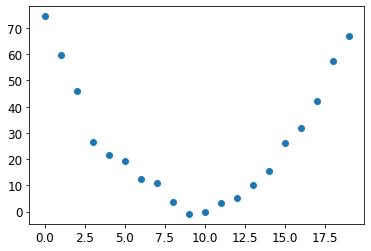

In [ ]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

我们加入了一些随机噪声，因为手动测量并不精确。这意味着“过山车的速度是多少？”这个问题没那么容易回答。借助随机梯度下降（SGD），我们可以尝试找到一个与观测数据相匹配的函数。我们无法考虑所有可能的函数，所以不妨假设它是一个二次函数，即形式为`a*(time**2)+(b*time)+c`的函数。

我们希望清晰区分函数的输入（测量过山车速度的时间）和参数（定义我们所尝试的具体二次函数的数值）。因此，我们将参数集中到一个参数中，这样在函数签名中就能把输入`t`和参数`params`区分开来：

In [ ]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

换句话说，我们将寻找能拟合数据的最佳函数这一问题，限定为寻找最佳**二次函数**。这极大地简化了问题，因为每个二次函数都由`a`、`b`、`c`这三个参数完全确定。因此，要找到最佳二次函数，我们只需找到`a`、`b`、`c`的最佳值即可。

如果我们能解决二次函数这三个参数的求解问题，那么对于其他具有更多参数的复杂函数（例如神经网络），我们也能应用相同的方法。让我们先找到函数`f`的参数，之后再回到MNIST数据集，用神经网络做同样的事情。

我们首先需要明确“最佳”的含义。我们通过选择**损失函数**来精确定义这一点，该函数会根据预测值和目标值返回一个数值，函数值越小表示预测“越好”。对于连续数据，常用的是**均方误差**：

In [ ]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

现在，让我们逐步完成这7个步骤。

#### 步骤1：初始化参数

首先，我们将参数初始化为随机值，并使用`requires_grad_`告诉PyTorch我们要跟踪它们的梯度：

In [ ]:
params = torch.randn(3).requires_grad_()

In [ ]:
#hide
orig_params = params.clone()

#### 步骤2：计算预测值

接下来，我们计算预测值：

In [ ]:
preds = f(time, params)

让我们创建一个小函数来查看预测值与目标值的接近程度，并来看一下结果：

In [ ]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

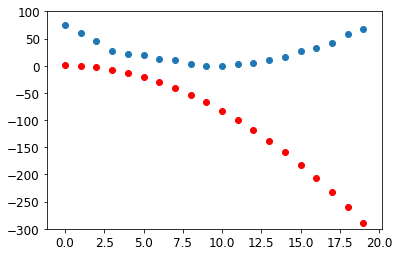

In [ ]:
show_preds(preds)

这看起来差距很大——我们随机初始化的参数表明过山车最终会向后行驶，因为出现了负的速度！

#### 步骤3：计算损失

我们按如下方式计算损失：

In [ ]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

我们现在的目标是改进这一点。要做到这一点，我们需要知道梯度。

#### 步骤4：计算梯度

下一步是计算梯度。换句话说，就是计算参数需要如何调整的近似值：

In [ ]:
loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [ ]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

我们可以利用这些梯度来改进参数。我们需要选择一个学习率（下一章会讨论实际中如何选择学习率；这里我们先使用1e-5，即0.00001）：

In [ ]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

#### 步骤5：更新权重。

现在我们需要根据刚才计算出的梯度来更新参数：

In [ ]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

> 亚历克西斯：要理解这部分内容，需要回顾一下前面的内容。为了计算梯度，我们对`loss`调用`backward`方法。但这个`loss`本身是通过`mse`计算得到的，而`mse`又以`preds`作为输入，`preds`则是通过函数`f`计算得出的，`f`的输入是`params`，而我们最初正是在`params`上调用了`required_grads_`——正是这个最初的调用，使得我们现在能够对`loss`调用`backward`方法。这一连串的函数调用代表了函数的数学复合，这让PyTorch能够在底层利用微积分中的链式法则来计算这些梯度。

让我们看看损失是否有所改善：

In [ ]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

再来看一下图表：

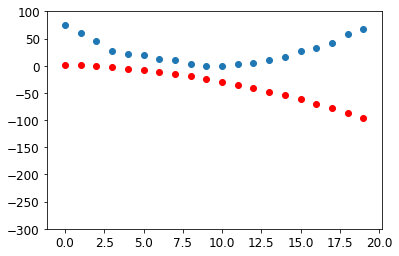

In [ ]:
show_preds(preds)

我们需要重复这个过程几次，所以我们会创建一个函数来执行一次迭代步骤：

In [ ]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### 步骤6：重复该过程

现在我们进行迭代。通过循环并执行多次改进，我们期望得到一个理想的结果：

In [ ]:
for i in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


In [ ]:
#hide
params = orig_params.detach().requires_grad_()

损失正在下降，这正合我们所愿！但仅看这些损失数值，掩盖了一个事实：在找到最佳二次函数的过程中，每一次迭代都代表着我们在尝试一个全新的二次函数。如果我们不打印损失函数，而是在每一步都绘制出该函数，就能直观地看到这个过程。这样我们就能观察到，函数的形状是如何逐步逼近最适合我们数据的二次函数的：

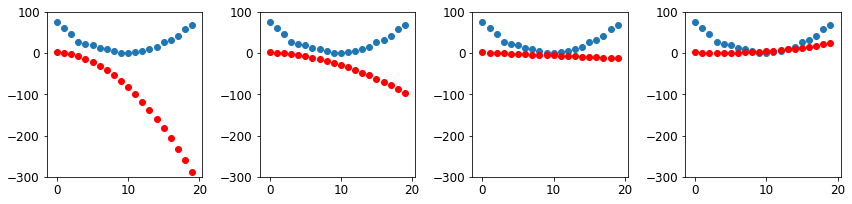

In [ ]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### 步骤7：停止

我们刚才随意决定在10个 epoch 后停止。在实际应用中，正如我们所讨论的，我们会通过观察训练损失、验证损失以及各项指标来决定何时停止。

### 梯度下降总结

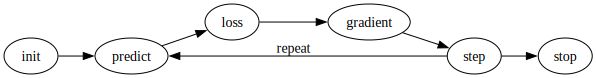

In [4]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

总结一下，一开始，我们模型的权重可以是随机的（即“从头开始”训练），也可以来自一个预训练模型（即“迁移学习”）。在前一种情况下，模型从输入得到的输出与我们期望的结果毫无关系；即便是后一种情况，预训练模型也很可能在我们的特定任务上表现不佳。因此，模型需要“学习”更优的权重。

我们首先使用“损失函数”来比较模型给出的输出与目标值（我们有带标签的数据，所以知道模型应该给出什么结果），损失函数会返回一个数值，我们的目标是通过改进权重让这个数值尽可能小。具体来说，我们从训练集中选取一些数据（比如图像）输入模型，用损失函数对比对应的目标值，得到的分数能告诉我们预测结果有多差。然后，我们对权重做微小调整，让结果稍好一些。

为了确定如何调整权重才能降低损失，我们会用微积分来计算“梯度”（实际上，这项工作是由PyTorch代劳的！）。我们可以用一个类比来理解：假设你在山里迷路了，而你的车停在地势最低的地方。要回到车旁，你可能会随机乱走，但这很可能没什么用。既然你知道车在最低点，那么沿着下坡走会更好。只要始终朝着最陡峭的下坡方向迈步，最终应该能到达目的地。我们用梯度的大小（即坡度的陡峭程度）来决定步长；具体来说，我们会将梯度乘以一个我们选定的数值（称为“学习率”），以此确定步长。之后不断“迭代”，直到到达最低点（也就是停车的地方），然后就可以“停止”了。

除了损失函数之外，我们刚才所讲的所有内容都可以直接套用到MNIST数据集上。接下来，我们来看看如何定义一个好的训练目标。

## MNIST损失函数

我们已经有了自变量`x`——也就是图像本身。我们要将所有图像拼接成一个单一的张量，同时把它们从矩阵列表（三维张量）转换为向量列表（二维张量）。这可以通过`view`方法实现，`view`是PyTorch中一个不改变张量内容但能调整其形状的方法。`-1`是`view`的一个特殊参数，意思是“根据所有数据的总量，自动确定该维度的大小”：

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

我们需要为每张图像标注标签。我们将用`1`表示数字3，用`0`表示数字7：

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

在PyTorch中，`Dataset`（数据集）在被索引时需要返回一个`(x,y)`形式的元组。Python提供了`zip`函数，将其与`list`结合使用，就能简单实现这一功能：

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

现在我们需要为每个像素设置一个（初始为随机的）权重（这是我们七步流程中的“初始化”步骤）：

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

函数`weights*pixels`的灵活性不足——当像素值为0时，该函数的值始终为0（即它的“截距”为0）。你可能还记得高中数学里的直线方程`y = w*x + b`；我们还需要这个`b`（偏置项）。我们也会将其初始化为一个随机数：

In [ ]:
bias = init_params(1)

在神经网络中，方程`y = w*x + b`里的`w`被称为“权重”，`b`被称为“偏置”。权重和偏置共同构成了“参数”。

> 术语：参数（Parameters）：模型的“权重”（weights）和“偏置”（biases）。权重是方程`w*x + b`中的`w`，偏置是该方程中的`b`。

现在我们可以为一张图像计算预测结果了：

In [ ]:
(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

虽然我们可以用Python的`for`循环来计算每张图像的预测结果，但这样做会非常慢。因为Python循环无法在GPU上运行，而且总体来说，Python语言处理循环的速度本身就很慢，所以我们需要尽可能地用更高级的函数来表示模型中的计算过程。

在这种情况下，有一种极为便捷的数学运算可以计算矩阵每一行的`w*x`——它被称为“矩阵乘法”。下图展示了矩阵乘法的形式。

<img alt="Matrix multiplication" width="400" caption="Matrix multiplication" src="images/matmul2.svg" id="matmul"/>

这张图展示了两个矩阵`A`和`B`相乘的过程。结果矩阵（我们称之为`AB`）中的每个元素，都是由`A`中对应行的每个元素与`B`中对应列的每个元素相乘后再求和得到的。例如，第1行第2列的元素（带红色边框的橙色点）的计算方式为$a_{1,1} * b_{1,2} + a_{1,2} * b_{2,2}$。如果你需要复习矩阵乘法的相关知识，建议查看可汗学院（Khan Academy）的《矩阵乘法入门》（[Intro to Matrix Multiplication](https://youtu.be/kT4Mp9EdVqs)），因为这是深度学习中最重要的数学运算。

在Python中，矩阵乘法用`@`运算符表示。我们来试一下：

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

第一个元素与我们之前计算的结果一致，这符合预期。`batch@weights + bias`这个方程，是所有神经网络的两个基本方程之一（另一个是“激活函数”，我们马上就会讲到）。

我们来检查一下准确率。要判断输出结果代表的是3还是7，只需看它是否大于0即可。因此，每个样本的准确率可以通过以下方式计算（借助广播机制，无需循环！）：

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [ ]:
corrects.float().mean().item()

0.4912068545818329

现在我们来看看，当其中一个权重发生微小变化时，准确率会有怎样的变化：

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

如我们所见，要使用随机梯度下降（SGD）改进模型，就需要梯度；而要计算梯度，就需要一个能反映模型表现好坏的“损失函数”。这是因为梯度衡量的是，当权重发生微小调整时，损失函数会发生怎样的变化。

因此，我们需要选择一个损失函数。一个显而易见的思路是，将作为评价指标的准确率同时用作损失函数。在这种情况下，我们会计算每张图像的预测结果，汇总这些结果以得到整体准确率，然后计算每个权重相对于该整体准确率的梯度。

但遗憾的是，这里存在一个严重的技术问题。函数的梯度指的是它的“斜率”或陡峭程度，其定义为“上升量除以运行量”——即函数值的变化量除以输入的变化量。用数学式子可以表示为：`(y_new - y_old) / (x_new - x_old)`。当`x_new`与`x_old`非常接近（即它们的差值极小）时，这个式子能很好地近似梯度。但准确率只有在预测结果从3变为7（或反之）时才会发生变化。问题在于，权重从`x_old`到`x_new`的微小变化不太可能导致任何预测结果发生改变，因此`(y_new - y_old)`几乎总是为0。换句话说，梯度在几乎所有地方都是0。

权重的微小变化通常根本不会改变准确率。这意味着将准确率用作损失函数是不可行的——如果我们这样做，大多数时候梯度实际上会是0，模型无法从这个数值中学习。

> 西尔万：补充说明：从数学角度来讲，准确率是一个几乎在所有地方都恒定的函数（除了阈值0.5处），因此它的导数几乎在所有地方都为0（在阈值处为无穷大）。这会导致梯度不是0就是无穷大，而这两种情况对模型更新都毫无用处。

相反，我们需要这样一种损失函数：当模型权重使预测结果稍有改善时，损失值也能随之稍有降低。那么，“稍有改善的预测”具体是什么样的呢？在这种情况下，它意味着：如果正确答案是3，那么得分要稍高一些；如果正确答案是7，那么得分要稍低一些。

现在我们来构建这样一个函数。它会是什么形式呢？

损失函数的输入不是图像本身，而是模型的预测结果。我们设定一个参数`prds`，其值介于0到1之间，每个值代表图像是3的预测概率。它是一个向量（即一维张量），按图像进行索引。

损失函数的目的是衡量预测值与真实值（即目标值，又称标签）之间的差异。我们再设定另一个参数`trgts`，其值为0或1，用于表示图像实际上是不是3。它也是一个向量（即另一个一维张量），同样按图像进行索引。

例如，假设我们有三张图像，已知它们分别是3、7、3。假设我们的模型以较高的置信度（0.9）预测第一张是3，以较低的置信度（0.4）预测第二张是7，而对第三张图像的预测虽然有一定置信度（0.2），但错误地认为它是7。那么，我们的损失函数会接收以下值作为输入：

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

下面是对损失函数的首次尝试，它用于衡量“预测值”（predictions）与“目标值”（targets）之间的差距：

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

我们在这里使用了一个新函数`torch.where(a, b, c)`。它的作用等同于列表推导式`[b[i] if a[i] else c[i] for i in range(len(a))]`，但它适用于张量，并且能以C/CUDA的速度运行。用通俗的话来说，这个函数会计算：对于本应是1的情况，每个预测值与1的距离；对于本应是0的情况，每个预测值与0的距离，然后取所有这些距离的平均值。

> 注意：查阅文档：了解这类PyTorch函数很重要，因为在Python中对张量进行循环的速度是Python级别的，而非C/CUDA级别！现在可以尝试运行`help(torch.where)`来阅读这个函数的文档，或者更好的方式是去PyTorch的官方文档网站上查阅。

让我们在`prds`和`trgts`上试一下这个函数：

In [ ]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

可以看出，当预测更准确时、当准确的预测置信度更高（绝对值更大）时，以及当不准确的预测置信度更低时，这个函数返回的值会更小。在PyTorch中，我们始终默认损失函数的值越小越好。由于我们需要一个标量作为最终的损失值，`mnist_loss`会取之前张量的平均值：

In [ ]:
mnist_loss(prds,trgts)

tensor(0.4333)

例如，如果我们将那个“错误”目标的预测值从`0.2`改为`0.8`，损失值就会下降，这表明这是一个更好的预测：

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

当前定义的`mnist_loss`存在一个问题，即它假设预测值始终介于0和1之间。因此，我们需要确保实际情况确实如此！碰巧的是，有一个函数正好能实现这一点——我们来看看它。

### Sigmoid

`sigmoid`（ sigmoid函数）的输出值始终在0到1之间。其定义如下：

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

PyTorch为我们定义了一个经过加速的版本，所以我们其实不需要自己去实现。这是深度学习中一个重要的函数，因为我们经常需要确保数值处于0到1之间。它的图像如下：

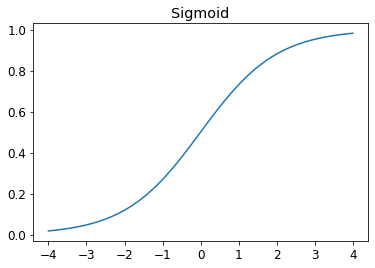

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

如你所见，它接收任意输入值（无论正负），并将其压缩到0到1之间的输出值。同时，它是一条单调递增的平滑曲线，这使得随机梯度下降（SGD）更容易找到有意义的梯度。

让我们更新`mnist_loss`，先对输入应用`sigmoid`函数：

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

现在我们可以确信，即便预测值不在0到1之间，我们的损失函数也能正常工作。只需要满足一点：预测值越高，代表图像是3的置信度越高。

定义好损失函数后，现在是时候回顾一下我们为什么要这么做了。毕竟，我们已经有了一个评价指标，也就是整体准确率。那为什么还要定义损失呢？

关键区别在于：评价指标是为了帮助人类理解模型表现，而损失是为了驱动模型自动学习。要驱动自动学习，损失函数必须是一个具有有意义导数的函数。它不能有大面积的平坦区域和剧烈的跳跃，而应该是相对平滑的。这就是我们设计的损失函数会对置信度的微小变化做出反应的原因。这一要求意味着，损失函数有时可能并不完全反映我们真正想要达成的目标，而是在我们的实际目标与可通过梯度优化的函数之间的一种妥协。损失函数会针对数据集中的每个样本进行计算，然后在一个 epoch 结束时，所有损失值会被求平均，得到该 epoch 的整体平均损失并进行报告。

另一方面，评价指标是我们真正关心的数值。这些数值会在每个 epoch 结束时被打印出来，告诉我们模型的实际表现如何。在判断模型性能时，我们要学会关注这些评价指标，而不是损失，这一点很重要。

### 随机梯度下降（SGD）与小批量（Mini-Batches）

既然我们已经有了一个适合驱动随机梯度下降（SGD）的损失函数，接下来就可以考虑学习过程下一阶段涉及的一些细节了——即基于梯度来调整或更新权重，这一步被称为“优化步骤”。

要执行优化步骤，我们需要计算一个或多个数据样本的损失。那应该用多少个样本呢？我们可以计算整个数据集的损失并取平均值，也可以只计算单个数据样本的损失，但这两种方法都不够理想。计算整个数据集的损失会耗费大量时间；而仅用单个样本计算损失则信息利用不足，会导致梯度估计非常不精确且不稳定——也就是说，你费力去更新权重，却只考虑了这一更新对模型在单个样本上表现的提升。

因此，我们采取了一种折中的方法：每次计算少量数据样本的平均损失。这少量样本被称为“小批量”（mini-batch），小批量中数据样本的数量则称为“批量大小”（batch size）。批量大小越大，从损失函数中得到的数据集梯度估计就越准确、越稳定，但计算耗时也会更长，且每个 epoch 中处理的小批量数量会更少。选择合适的批量大小是深度学习实践者为快速且准确地训练模型需要做出的决策之一，本书会在多处探讨如何做出这一选择。

使用小批量而非基于单个数据样本计算梯度的另一个重要原因是，在实际训练中，我们几乎总是使用 GPU 等加速器。这些加速器只有在同时处理大量任务时才能发挥出良好性能，因此给它们提供大量数据样本是很有帮助的，而使用小批量正是实现这一点的最佳方式之一。不过，若一次性给它们太多数据，会导致内存不足——要让 GPU 高效工作也并非易事！

正如我们在第 <<第二章>> 章讨论数据增强时所提到的，在训练过程中引入变化有助于模型获得更好的泛化能力。其中一个简单且有效的做法是，改变每个小批量中包含的数据样本。我们通常不会在每个 epoch 中都按固定顺序遍历数据集，而是在创建小批量之前，先对整个数据集进行随机打乱。PyTorch 和 fastai 提供了一个名为 `DataLoader` 的类，它可以自动完成数据打乱和小批量整理的工作。

`DataLoader` 可以接收任何 Python 集合，并将其转换为一个可迭代的批量迭代器，示例如下：

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

在训练模型时，我们需要的并非任意Python集合，而是包含自变量和因变量（即模型的输入和目标值）的集合。在PyTorch中，这种包含自变量与因变量元组的集合被称为`Dataset`（数据集）。以下是一个极其简单的`Dataset`示例：

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

当我们将一个`Dataset`（数据集）传入`DataLoader`时，会得到许多批量数据，这些批量数据本身是由张量组成的元组，分别代表自变量批量和因变量批量：

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

现在我们可以编写第一个使用随机梯度下降（SGD）训练模型的循环了！

## 整合所有内容

现在是时候实现我们在《梯度下降》中介绍的流程了。在代码中，对于每个 epoch，我们的实现过程大致如下：

```python
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
```

首先，让我们重新初始化参数：

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

可以从`Dataset`（数据集）创建`DataLoader`（数据加载器）：

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

我们会对验证集执行相同的操作：

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

让我们创建一个大小为4的小批量用于测试：

In [ ]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [ ]:
preds = linear1(batch)
preds

tensor([[-11.1002],
        [  5.9263],
        [  9.9627],
        [ -8.1484]], grad_fn=<AddBackward0>)

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.5006, grad_fn=<MeanBackward0>)

现在我们可以计算梯度了：

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0001), tensor([-0.0008]))

让我们把这些都整合到一个函数中：

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

并对其进行测试：

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0002), tensor([-0.0015]))

但看看如果我们调用它两次会发生什么：

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0003), tensor([-0.0023]))

梯度发生变化了！原因在于`loss.backward`实际上会将`loss`的梯度**加到**当前存储的任何梯度上。因此，我们必须先将当前梯度设置为0：

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

> 注意：原地操作（Inplace Operations）：PyTorch中名称以下划线结尾的方法会**原地**修改其对象。例如，`bias.zero_()`会将张量`bias`的所有元素设为0。

我们仅剩的步骤是根据梯度和学习率来更新权重和偏置。在执行这一步时，我们也必须告诉PyTorch不要计算这一步的梯度——否则，当我们尝试计算下一个批次的导数时，情况会变得非常混乱！如果我们对张量的`data`属性进行赋值，PyTorch就不会计算该步骤的梯度。以下是一个epoch的基本训练循环：

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

我们还希望通过查看验证集的准确率来了解模型的表现。要判断输出结果代表的是3还是7，只需检查输出值是否大于0即可。因此，每个样本的准确率可以通过以下方式计算（借助广播机制，无需循环）：

In [ ]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [False]])

这就有了一个计算验证集准确率的函数：

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

我们可以检查它是否能正常工作：

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

然后将这些批次整合起来：

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

0.5219

这就是我们的起点。让我们训练一个 epoch，看看准确率是否有所提高：

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6883

然后再进行几次（训练）：

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8314 0.9017 0.9227 0.9349 0.9438 0.9501 0.9535 0.9564 0.9594 0.9618 0.9613 0.9638 0.9643 0.9652 0.9662 0.9677 0.9687 0.9691 0.9691 0.9696 

看起来效果不错！我们的准确率已经差不多达到了“像素相似度”方法的水平，而且我们还搭建了一个可扩展的通用基础框架。下一步，我们将创建一个能为我们处理SGD步骤的对象。在PyTorch中，这个对象被称为**优化器（optimizer）**。

### 创建优化器（optimizer）

由于这是一个非常通用的基础框架，PyTorch提供了一些实用的类来简化实现过程。首先，我们可以用PyTorch的`nn.Linear`模块替换我们的`linear1`函数。**模块（module）** 是继承自PyTorch的`nn.Module`类的对象。这类对象的行为与标准Python函数完全一致，你可以用括号调用它们，它们会返回模型的激活值。

`nn.Linear`的功能相当于我们的`init_params`和`linear`函数的组合。它在一个类中同时包含了**权重（weights）** 和**偏置（biases）**。以下是如何复现上一节中的模型：

In [ ]:
linear_model = nn.Linear(28*28,1)

每个PyTorch模块都知道自身拥有哪些可训练的参数；这些参数可以通过`parameters`方法获取：

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

我们可以利用这一信息来创建优化器：

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

我们可以通过传入模型的参数来创建优化器：

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

我们的训练循环现在可以简化为：

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

我们的验证函数完全不需要修改：

In [ ]:
validate_epoch(linear_model)

0.4157

让我们把这个小型训练循环封装到一个函数中，这样能让事情更简单：

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

结果与上一节相同：

In [ ]:
train_model(linear_model, 20)

0.4932 0.8618 0.8203 0.9102 0.9331 0.9468 0.9555 0.9629 0.9658 0.9673 0.9687 0.9707 0.9726 0.9751 0.9761 0.9761 0.9775 0.978 0.9785 0.9785 

fastai提供了`SGD`类，默认情况下，它的功能与我们的`BasicOptim`相同：

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.852 0.8335 0.9116 0.9326 0.9473 0.9555 0.9624 0.9648 0.9668 0.9692 0.9712 0.9731 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.9785 

fastai还提供了`Learner.fit`方法，我们可以用它来替代`train_model`。要创建一个`Learner`，首先需要创建一个`DataLoaders`对象，方法是传入我们的训练集`DataLoader`和验证集`DataLoader`：

In [ ]:
dls = DataLoaders(dl, valid_dl)

如果不使用应用程序（例如`cnn_learner`）来创建`Learner`，我们需要传入本章中创建的所有元素：`DataLoaders`、模型、优化函数（会传入参数）、损失函数，还可以选择性地传入需要打印的指标：

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

现在我们可以调用`fit`了：

In [ ]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636857,0.503549,0.495584,00:00
1,0.545725,0.170281,0.866045,00:00
2,0.199223,0.184893,0.831207,00:00
3,0.086580,0.107836,0.911187,00:00
4,0.045185,0.078481,0.932777,00:00
5,0.029108,0.062792,0.946516,00:00
6,0.022560,0.053017,0.955348,00:00
7,0.019687,0.046500,0.962218,00:00
8,0.018252,0.041929,0.965162,00:00
9,0.017402,0.038573,0.967615,00:00


正如你所见，PyTorch和fastai中的类并没有什么神奇之处。它们只是方便的预包装组件，能让你的工作轻松一点！（它们还提供了许多额外功能，我们将在后续章节中使用。）

有了这些类，我们现在就可以用神经网络替换线性模型了。

## 添加非线性激活函数

到目前为止，我们已经掌握了一种优化函数参数的通用流程，并且在一个非常简单的函数——简单线性分类器上进行了实践。线性分类器的功能非常有限。为了让它更复杂一些（并能处理更多任务），我们需要在两个线性分类器之间添加一些非线性的东西——这就是构成神经网络的关键。

以下是一个基础神经网络的完整定义：

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

就是这样！`simple_net` 中只有两个线性分类器，它们之间有一个 `max` 函数。

这里，`w1` 和 `w2` 是权重张量，`b1` 和 `b2` 是偏置张量；也就是说，这些参数最初是随机初始化的，就像我们在上一节中所做的那样：

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

这里的关键在于，`w1` 有 30 个输出激活值（这意味着 `w2` 必须有 30 个输入激活值，这样它们才能匹配）。这意味着第一层可以构建 30 种不同的特征，每种特征都代表像素的某种不同组合。你可以将这个 `30` 改成任何你喜欢的值，从而调整模型的复杂程度。

`res.max(tensor(0.0))` 这个小函数被称为**整流线性单元（rectified linear unit）**，也称为**ReLU**。我们都觉得“整流线性单元”听起来相当高端复杂……但实际上，它的作用只不过是 `res.max(tensor(0.0))`——换句话说，就是把所有负数替换成零。这个简单的函数在 PyTorch 中也可以通过 `F.relu` 调用：

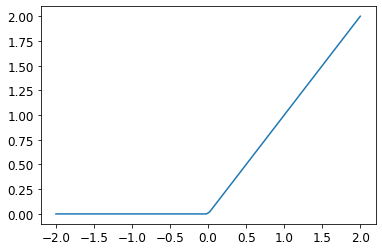

In [ ]:
plot_function(F.relu)

> 杰里米：深度学习领域有大量的行话，比如“整流线性单元（rectified linear unit）”。但绝大多数行话所对应的概念，复杂程度都不超过几行代码就能实现的范畴，就像我们在这个例子中看到的那样。事实上，学者们为了让论文得以发表，往往需要让内容听起来尽可能令人印象深刻且复杂高深。创造行话就是他们常用的手段之一。遗憾的是，这导致这个领域变得比它本该有的样子更令人望而生畏，也更难入门。你确实需要学习这些行话，否则论文和教程对你来说就没什么意义。但这并不意味着你必须被这些行话吓倒。只需记住，当你遇到没见过的词语或短语时，它几乎必然指向一个非常简单的概念。

核心思想是，通过使用更多的线性层，我们的模型可以进行更多计算，从而能够拟合更复杂的函数。但如果只是将一个线性层直接放在另一个线性层之后，这样做是没有意义的——因为多次进行乘法和加法运算的组合，其实可以等价于用不同的参数进行一次乘法和加法运算！也就是说，任意数量的线性层串联在一起，其效果都可以被一个具有不同参数集的单一线性层替代。

但如果我们在它们之间加入非线性函数（比如`max`函数），情况就不再如此了。此时，每个线性层实际上在一定程度上彼此解耦，能够各自完成有用的计算。`max`函数尤其有意思，因为它的作用相当于一个简单的`if`语句。

> 西尔万：从数学角度来说，两个线性函数的复合仍然是一个线性函数。因此，无论我们在彼此之上堆叠多少个线性分类器，如果它们之间没有非线性函数，其效果都等同于一个单一的线性分类器。

令人惊叹的是，从数学上可以证明：只要能为`w1`和`w2`找到合适的参数，并且将这些矩阵做得足够大，这个简单的函数就能以任意高的精度解决任何可计算问题。对于任何复杂的波动函数，我们都可以将其近似为一系列线段的拼接；要让这个近似更接近原函数，只需使用更短的线段即可。这就是所谓的**通用近似定理（universal approximation theorem）**。我们这里的三行代码被称为**层（layers）**。第一行和第三行称为**线性层（linear layers）**，第二行代码则有多种称呼，如**非线性层（nonlinearity）** 或**激活函数（activation function）**。

和上一节一样，我们可以利用PyTorch的特性，用更简洁的代码替代这段实现：

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

`nn.Sequential` 会创建一个模块，该模块将依次调用列出的各个层或函数。

`nn.ReLU` 是 PyTorch 中的一个模块，其功能与 `F.relu` 函数完全相同。模型中可能出现的大多数函数都有对应的模块形式，通常只需将 `F` 替换为 `nn` 并调整首字母大小写即可。在使用 `nn.Sequential` 时，PyTorch 要求我们使用模块版本。由于模块是类，我们必须对其进行实例化，这就是在本例中看到 `nn.ReLU()` 的原因。

由于 `nn.Sequential` 是一个模块，我们可以获取它的参数，这会返回它所包含的所有模块的所有参数的列表。让我们来尝试一下！因为这是一个更深的模型，我们会使用更低的学习率和更多的训练轮次。

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.305828,0.399663,0.508341,00:00
1,0.142960,0.225702,0.807655,00:00
2,0.079516,0.113519,0.919529,00:00
3,0.052391,0.076792,0.943081,00:00
4,0.039796,0.060083,0.956330,00:00
5,0.033368,0.050713,0.963690,00:00
6,0.029680,0.044797,0.965653,00:00
7,0.027290,0.040729,0.968106,00:00
8,0.025568,0.037771,0.968597,00:00
9,0.024233,0.035508,0.970559,00:00


为了节省篇幅，我们这里不展示40行的输出内容；训练过程记录在`learn.recorder`中，输出表格存储在`values`属性里，因此我们可以像这样绘制训练过程中的准确率曲线：

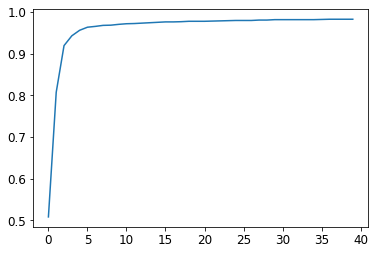

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

我们可以查看最终的准确率：

In [ ]:
learn.recorder.values[-1][2]

0.982826292514801

到目前为止，我们已经掌握了一些看似神奇的东西：

1. 一个只要有正确的参数集，就能以任意精度解决任何问题的函数（即神经网络）
2. 一种为任意函数找到最佳参数集的方法（即随机梯度下降）

这就是深度学习能够实现那些看似神奇、令人惊叹的功能的原因。许多学生需要迈出的最大一步之一，就是相信这种简单技术的组合真的能够解决任何问题。这似乎好得让人难以置信——事情肯定应该比这更困难、更复杂才对？我们的建议是：亲自尝试一下！我们刚刚在MNIST数据集上进行了尝试，你也已经看到了结果。而且，由于除了计算梯度之外，所有步骤都是我们从零开始实现的，所以你知道，这背后并没有隐藏什么特殊的魔法。

### 加深网络深度

我们不必局限于只使用两个线性层。只要在每对线性层之间添加非线性激活函数，我们可以根据需要添加任意多个线性层。不过，你会发现，模型越深，实际上优化参数就越困难。在本书的后续内容中，你将学到一些简单但极其有效的技术，用于训练更深层次的模型。

我们已经知道，带有两个线性层和一个非线性激活函数的模型就足以近似任何函数。那么，我们为什么还要使用更深的模型呢？原因在于性能。使用更深的模型（即具有更多层的模型）时，我们不需要使用那么多参数；事实证明，我们可以通过使用更小的矩阵和更多的层，获得比使用更大的矩阵但更少的层更好的结果。

这意味着我们可以更快地训练模型，而且模型占用的内存也更少。在20世纪90年代，研究人员过于关注通用近似定理，很少有人尝试使用超过一个非线性激活函数的模型。这种理论上可行但实际应用中并不适用的基础，阻碍了该领域多年的发展。然而，一些研究人员确实对深度模型进行了实验，并最终证明这些模型在实际应用中表现得更好。后来，相关的理论结果也被提出，解释了为什么会出现这种情况。如今，使用只含一个非线性激活函数的神经网络是极为罕见的。

下面是使用我们在《第一章》中看到的相同方法训练一个18层模型的结果：

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.082089,0.009578,0.997056,00:11


准确率接近100%！这与我们的简单神经网络相比有很大差异。但正如你将在本书剩余部分学到的，要从零开始获得如此出色的结果，只需要掌握几个小技巧而已。你已经了解了关键的基础内容。（当然，即便你掌握了所有技巧，也几乎总会希望使用PyTorch和fastai提供的预构建类，因为它们能让你不必亲自考虑所有细节。）

## 术语回顾

恭喜你：现在你已经知道如何从零开始创建并训练一个深度神经网络了！为了达到这一步，我们经历了不少步骤，但你可能会惊讶于它实际上是如此简单。

到了这里，正好是定义和回顾一些术语及关键概念的好时机。

一个神经网络包含许多数值，但它们只分为两类：经过计算得到的数值，以及用于计算这些数值的参数。这就引出了两个我们需要学习的最重要的术语：

- **激活值（Activations）**：经过计算得到的数值（既包括线性层的计算结果，也包括非线性层的计算结果）
- **参数（Parameters）**：随机初始化并经过优化的数值（即定义模型的数值）

在本书中，我们会经常提到激活值和参数。记住，它们有着非常具体的含义。它们是数值，不是抽象的概念，而是模型中实际存在的具体数值。成为一名优秀的深度学习实践者，部分在于要习惯去实际查看激活值和参数，对它们进行可视化，并检验它们的表现是否正常。

我们的激活值和参数都包含在**张量（tensors）** 中。张量就是形状规则的数组——例如矩阵。矩阵有行和列；我们称这些为**轴（axes）** 或**维度（dimensions）**。张量的维度数量称为它的**阶（rank）**。有一些特殊的张量：

- 0阶张量：标量
- 1阶张量：向量
- 2阶张量：矩阵

一个神经网络包含多个层。每个层要么是**线性的（linear）**，要么是**非线性的（nonlinear）**。在神经网络中，我们通常会交替使用这两种类型的层。有时，人们会将一个线性层及其后续的非线性层合在一起称为一个层。没错，这确实容易让人混淆。有时，非线性层也被称为**激活函数（activation function）**。

下面深度学习词汇表总结了与随机梯度下降（SGD）相关的关键概念。





|术语|含义|
|:-------:|:---|
|ReLU | 对负数返回0，对正数不做改变的函数。|
|小批量（Mini-batch） | 集中在两个数组中的一小组输入和标签。梯度下降的参数更新步骤基于这个批量（而非整个 epoch）进行。|
|前向传播（Forward pass） | 将模型应用于某些输入并计算预测结果的过程。|
|损失（Loss） | 表示模型表现好坏的数值。|
|梯度（Gradient） | 损失相对于模型某个参数的导数。|
|反向传播（Backward pass） | 计算损失相对于所有模型参数的梯度的过程。|
|梯度下降（Gradient descent） | 朝着与梯度相反的方向迈出一步，使模型参数得到些许改进。|
|学习率（Learning rate） | 应用随机梯度下降（SGD）更新模型参数时所采取的步长大小。|


> 注意：《自主选择探索之旅》提醒：你是否因为急于深入了解底层原理而跳过了第2章和第3章？那么在此提醒你，现在该回到第2章了，因为你很快就会需要用到那里的知识！

## 练习题

1. 灰度图像在计算机上如何表示？彩色图像呢？
1. `MNIST_SAMPLE`数据集的文件和文件夹是如何组织的？为什么要这样组织？
1. 解释用于数字分类的“像素相似度”方法是如何工作的。
1. 什么是列表推导式？现在创建一个列表推导式，从一个列表中选出奇数并将其翻倍。
1. 什么是“三维张量”？
1. 张量的秩和形状有什么区别？如何从形状中得到秩？
1. 什么是均方根误差（RMSE）和L1范数？
1. 如何一次性对数千个数字执行计算，且速度比Python循环快数千倍？
1. 创建一个包含1到9的3×3张量或数组。将其翻倍。选出右下角的四个数字。
1. 什么是广播机制？
1. 指标通常是使用训练集还是验证集来计算的？为什么？
1. 什么是随机梯度下降（SGD）？
1. 随机梯度下降为什么要使用小批量数据？
1. 机器学习中随机梯度下降的七个步骤是什么？
1. 我们如何初始化模型中的权重？
1. 什么是“损失”？
1. 为什么我们不能总是使用高学习率？
1. 什么是“梯度”？
1. 你需要知道如何自己计算梯度吗？
1. 为什么我们不能用准确率作为损失函数？
1. 画出sigmoid函数。它的形状有什么特别之处？
1. 损失函数和指标有什么区别？
1. 使用学习率计算新权重的函数是什么？
1. `DataLoader`类的作用是什么？
1. 写出随机梯度下降中每个 epoch 基本步骤的伪代码。
1. 创建一个函数，若传入两个参数`[1,2,3,4]`和`'abcd'`，返回`[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`。这个输出数据结构有什么特别之处？
1. PyTorch中的`view`方法有什么作用？
1. 神经网络中的“偏置”参数是什么？我们为什么需要它们？
1. Python中的`@`运算符有什么作用？
1. `backward`方法有什么作用？
1. 为什么我们要清零梯度？
1. 我们需要向`Learner`传递哪些信息？
1. 写出训练循环基本步骤的Python代码或伪代码。
1. 什么是“ReLU”？画出其在-2到+2取值范围内的图像。
1. 什么是“激活函数”？
1. `F.relu`和`nn.ReLU`有什么区别？
1. 万能逼近定理表明，只需一个非线性函数，就能以任意精度逼近任何函数。那么我们为什么通常要使用更多的非线性函数呢？

### 进一步研究

1. 基于本章展示的训练循环，从零开始实现你自己的`Learner`。
1. 使用完整的MNIST数据集（即包含所有数字，而不仅仅是3和7）完成本章中的所有步骤。这是一个重要的项目，需要你花费相当多的时间来完成！你需要自己做一些研究，以找到方法克服过程中遇到的一些障碍。